# Setting up env

## Import dataset to filepath

In [1]:
# Import dependencies
import pandas as pd
from string import punctuation
import re
import numpy as np
import tensorflow as tf
import os
import time
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [2]:
# Set up paths
DATA_FILEPATH = "/content/sample_data/data.csv"

## Load in the Data

In [3]:
def load_doc(filepath, mode):
    return pd.read_csv(filepath)

In [4]:
def get_pairs(filepath):

    # Get file contents
    df = load_doc(filepath, 'r')

    return df

In [5]:
# Load in the data
data = get_pairs(DATA_FILEPATH).sample(70000)
data.head()

,english,spanish
43911,He lost sight of the bird.,Él perdió de vista al pájaro.
6521,Let's hope not.,Esperemos que no.
45042,I'm so glad you showed up.,Me alegro mucho de que te hayas pasado.
49710,She read the poem out loud.,Ella leyó el poema en voz alta.
44734,I think Tom is very smart.,Creo que Tom es muy listo.


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 43911 to 113310
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  70000 non-null  object
 1   spanish  70000 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [7]:
# Hyperparameters
max_len = 30
enc_units = 1024
dec_units = 1024
embedding_dim = 256
EPOCHS = 30

# Data cleaning

## Preprocessing the Data

In [8]:
def preprocess_text(text):
    text = text.lower()
    text= re.sub("'", '', text)
    text = re.sub(r"\d", '', text)
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub("\s+", ' ',  text).strip()
    text=  'startseq ' + text + ' endseq'

    return text

In [9]:
# Preprocess inputs (English sentences)
data["inputs"] = data["english"].apply(lambda x: preprocess_text(x))

# Preprocess targets (Spanish sentences)
data["targets"] = data["spanish"].apply(lambda x: preprocess_text(x))

## Train-Test Split

In [10]:
train_inp, test_inp, train_tar, test_tar = train_test_split(data.inputs, data.targets,
                                                            test_size=0.2,
                                                            random_state=42)

print(f"Number of training samples : {len(train_inp)}")
print(f"Number of test samples     : {len(test_inp)}")

Number of training samples : 56000
Number of test samples     : 14000


## Tokenize and Pad the Sentences



In [11]:
class LanguageIndex():
    def __init__(self, sentences_list):
        self.tokenizer = None
        self.word2idx  = None

        self.get_tokenizer(sentences_list)
        self.get_word_to_idx_mapping()


    def get_tokenizer(self, sentences_list):
        self.tokenizer = Tokenizer(filters='', oov_token="<UNK>")
        self.tokenizer.fit_on_texts(sentences_list)

    def get_word_to_idx_mapping(self):
        self.word2idx = self.tokenizer.word_index


    def get_max_length(self, sentences):
        return max([len(line.split())  for line in sentences])

In [12]:
input_lang  = LanguageIndex([line  for line in data.inputs])
target_lang = LanguageIndex([line  for line in data.targets])

In [13]:
print(f"Length of the longest input (English) sentence : {input_lang.get_max_length(data.inputs)}")
print(f"Length of the longest target (Spanish) sentence : {target_lang.get_max_length(data.targets)}")

Length of the longest input (English) sentence : 51
Length of the longest target (Spanish) sentence : 53


In [14]:
# Tokenize input sentences
input_seqs_int = input_lang.tokenizer.texts_to_sequences(train_inp)
# Pad input sentences
input_seqs_int = pad_sequences(input_seqs_int, maxlen=max_len,  padding="post")


# Tokenize target sentences
target_seqs_int = target_lang.tokenizer.texts_to_sequences(train_tar)
# Pad target sentences
target_seqs_int = pad_sequences(target_seqs_int, maxlen=max_len, padding="post")

In [15]:
input_vocab_size = len(input_lang.word2idx) + 1
target_vocab_size = len(target_lang.word2idx) + 1

print(f"Vocab size for inputs (English sentences)  : {input_vocab_size}")
print(f"Vocab size for targets (Spanish sentences) : {target_vocab_size}")

Vocab size for inputs (English sentences)  : 11262
Vocab size for targets (Spanish sentences) : 20937


## Creating Training Dataset

In [16]:
BATCH_SIZE = 64

In [17]:
def get_training_dataset(X_train, y_train, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [18]:
# Get train dataset
train_dataset = get_training_dataset(input_seqs_int, target_seqs_int, batch_size=BATCH_SIZE)

## Define Optimizer and Loss Function

In [19]:
# Optimizer
optimizer = tf.keras.optimizers.Adam()


# Loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction="none")

def loss_func(actual_words, predicted_words_probability):
	loss = loss_object(actual_words, predicted_words_probability)
	mask = tf.where(actual_words > 0, 1.0, 0.0)
	return tf.reduce_sum(mask * loss)

# Get Model Encoder, Decoder and Additive-Attention Layer

In [20]:
def gru(units):
        return tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')


In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_units = encoder_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(encoder_units)

    def call(self, x, initial_state):
        x = self.embedding(x)
        enc_hidden_states, enc_output_state = self.gru(x, initial_state=initial_state)
        return enc_hidden_states, enc_output_state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))

### Additive attention layer

Bahdanau's algorithm encodes variable-length input into a variable-length vector as opposed to fixed-length in elementary seq2seq modeling to combat the squashing of information during training.

In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V  = tf.keras.layers.Dense(1)

    def call(self, enc_hidden_states,  dec_input_state):
        dec_input_state = tf.expand_dims(dec_input_state, axis=1)
        score = self.V(tf.nn.tanh(self.W1(dec_input_state) + self.W2(enc_hidden_states)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * enc_hidden_states
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(decoder_units)
        self.fc = tf.keras.layers.Dense(vocab_size, activation="softmax")
        self.attention = BahdanauAttention(self.decoder_units)

    def call(self, x, enc_hidden_states, dec_input_state):
        context_vector, attention_weights = self.attention(enc_hidden_states, dec_input_state)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [24]:
# Get the encoder
encoder = Encoder(input_vocab_size, embedding_dim, enc_units, BATCH_SIZE)

# Get the attention layer
attention_layer = BahdanauAttention(10)

# Get the decoder
decoder = Decoder(target_vocab_size, embedding_dim, dec_units, BATCH_SIZE)

## Establish Checkpoints

In [25]:
checkpoint_dir = "training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training the Model

In [26]:
@tf.function
def train_step(input, target, enc_hidden_state):
    loss = 0

    with tf.GradientTape() as tape:
        enc_hidden_states, enc_output_state = encoder(input, enc_hidden_state)
        # The last consolidated encoder hidden state is fed as input to the first
        # time step of the decoder.
        dec_hidden_state = enc_output_state

        # Set decoder input to be: 'startseq'
        # which is the ground truth for 0th time step
        dec_input = tf.expand_dims([target_lang.word2idx['startseq']] * BATCH_SIZE, axis=1)

        # Loop through each timestep
        for t in range(1, target.shape[1]):
            # dec_input : ground truth from the previous timestep
            # dec_hidden_state : hidden state of the decoder from previous timestep
            predictions, dec_hidden_state, _ = decoder(dec_input, enc_hidden_states, dec_hidden_state)

            # Calcuate loss for current time step and add it to get loss for all time steps
            loss += loss_func(target[:, t], predictions)

            # Set the ground truth as the next input of the decoder
            dec_input = tf.expand_dims(target[:, t], axis=1)


    # Calculate batch loss
    batch_loss = loss / int(target.shape[1])

    # Get the trainable variables
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # Derive gradients
    gradients = tape.gradient(loss, trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return batch_loss


In [27]:
loss_per_epoch = []

for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"Starting Epoch {epoch+1}")

    # Initialize encoder hidden state
    enc_hidden_state = encoder.initialize_hidden_state()

    loss_values = [] # Will store loss value for each batch in an epoch

    for batch, (input, target) in enumerate(train_dataset):
        batch_loss = train_step(input, target, enc_hidden_state)
        loss_values.append(batch_loss)


    # Save checkpoints every 10 epochs
    if (epoch == EPOCHS-1):
        checkpoint.save(file_prefix=checkpoint_prefix)

    # Save loss values
    loss_per_epoch.append(loss_values)

    print(f"Epoch {epoch+1},  Loss {np.mean(loss_values):.4f},   Time : {(time.time() - start_time):.1f} sec\n")

Starting Epoch 1
Epoch 1,  Loss 84.9429,   Time : 159.7 sec

Starting Epoch 2
Epoch 2,  Loss 53.2794,   Time : 105.0 sec

Starting Epoch 3
Epoch 3,  Loss 35.9126,   Time : 105.0 sec

Starting Epoch 4
Epoch 4,  Loss 26.2784,   Time : 104.9 sec

Starting Epoch 5
Epoch 5,  Loss 19.8022,   Time : 104.8 sec

Starting Epoch 6
Epoch 6,  Loss 15.3032,   Time : 104.9 sec

Starting Epoch 7
Epoch 7,  Loss 12.2027,   Time : 104.9 sec

Starting Epoch 8
Epoch 8,  Loss 10.1178,   Time : 105.1 sec

Starting Epoch 9
Epoch 9,  Loss 8.6361,   Time : 106.0 sec

Starting Epoch 10
Epoch 10,  Loss 6.7177,   Time : 105.7 sec

Starting Epoch 11
Epoch 11,  Loss 5.1476,   Time : 104.9 sec

Starting Epoch 12
Epoch 12,  Loss 4.2605,   Time : 105.0 sec

Starting Epoch 13
Epoch 13,  Loss 3.9885,   Time : 105.0 sec

Starting Epoch 14
Epoch 14,  Loss 3.1566,   Time : 104.9 sec

Starting Epoch 15
Epoch 15,  Loss 3.2845,   Time : 105.0 sec

Starting Epoch 16
Epoch 16,  Loss 2.7122,   Time : 105.0 sec

Starting Epoch 17


# Inference

In [28]:
def translate_text(input_text):

    # Preprocess the text
    text = preprocess_text(input_text)
    # Tokenize and pad the text
    text = [input_lang.word2idx[word]  for word in text.split()]
    text = pad_sequences([text], maxlen=max_len, padding="post")
    text = tf.convert_to_tensor(text)

    enc_hidden_state = tf.zeros((1, enc_units))
    enc_hidden_states, enc_output_state = encoder(text, enc_hidden_state)

    dec_hidden_state = enc_output_state
    dec_input = tf.expand_dims([target_lang.word2idx['startseq']], axis=1)

    output_text = ''
    for t in range(1, max_len):
        predictions, dec_hidden_state, attention_weights = decoder(dec_input,
                                                                   enc_hidden_states,
                                                                   dec_hidden_state)

        predicted_id = tf.argmax(predictions[0]).numpy()
        output_text += target_lang.tokenizer.index_word[predicted_id] + ' '

        if target_lang.tokenizer.index_word[predicted_id] == 'endseq':
            return output_text
        else:
            # Feed the predicted ID back into the model
            dec_input = tf.expand_dims([predicted_id], 0)

    return output_text

In [29]:
for i in range(5):
    rand_idx = random.choice(test_inp.index)
    print(f"English Text        : {' '.join(test_inp[rand_idx].split()[1:-1])}\n")
    print(f"Machine Translation : {' '.join(translate_text(test_inp[rand_idx]).split()[:-1])}")
    print(f"Correct Translation : {' '.join(test_tar[rand_idx].split()[1:-1])}")
    print("\n-------------------------------------------------------------------\n\n")

English Text        : let me tell you something .

Machine Translation : te lo que te huele .
Correct Translation : déjame decirte algo .

-------------------------------------------------------------------


English Text        : you go first .

Machine Translation : vaya usted primero .
Correct Translation : vos primero .

-------------------------------------------------------------------


English Text        : i thought it might be a possibility .

Machine Translation : pensé que podría ser una posibilidad .
Correct Translation : pensaba que podría ser una posibilidad .

-------------------------------------------------------------------


English Text        : help yourself to more potato chips .

Machine Translation : sírvete es más ayuda .
Correct Translation : servite más papas fritas .

-------------------------------------------------------------------


English Text        : i am going to the theater on the corner .

Machine Translation : me voy al teatro en la esquina .
Co

### Storing translations for evaluation

In [30]:
# storing inp   outp   actual
tups = []

for i in range(len(test_inp)):
  rand_idx = random.choice(test_inp.index)
  tups.append(
      (
          ' '.join(test_inp[rand_idx].split()[1:-1]),
          ' '.join(translate_text(test_inp[rand_idx]).split()[:-1]),
          ' '.join(test_tar[rand_idx].split()[1:-1])
      )
  )

In [31]:
for i in range(5):
  (inp, outp, actual) = tups[i]
  print(f"English Text        : {inp}\n")
  print(f"Machine Translation : {outp}")
  print(f"Correct Translation : {actual}")
  print("\n-------------------------------------------------------------------\n\n")


English Text        : tom will be at work on monday .

Machine Translation : tom va a estar en el lunes .
Correct Translation : tom estará trabajando el lunes .

-------------------------------------------------------------------


English Text        : tell me more .

Machine Translation : cuéntame más .
Correct Translation : cuénteme más .

-------------------------------------------------------------------


English Text        : i like listening to npr .

Machine Translation : me gusta escuchar las cosas .
Correct Translation : me gusta escuchar a la npr .

-------------------------------------------------------------------


English Text        : the jet plane had passengers on board .

Machine Translation : el plan necesita con los estados unidos .
Correct Translation : el avión tenía pasajeros a bordo .

-------------------------------------------------------------------


English Text        : my son can already count to one hundred .

Machine Translation : mi hijo ya sabe cont

## Storing variable data for later use

In [32]:
import pickle

In [33]:
SAVED_FILEPATH = "/content/sample_data/pickle_bahdanau.pkl"

# Open a file and use dump()
with open(SAVED_FILEPATH, 'wb') as file:

    # A new file will be created
    pickle.dump(tups, file)

In [34]:
# Open the file in binary mode
with open(SAVED_FILEPATH, 'rb') as file:

    # Call load method to deserialze
    myvar = pickle.load(file)

In [35]:
# For initial testing
# DO NOT RUN AFTER
print((myvar == tups))

True


# Visualizing Perplexity over Epochs

Goal: minimizing the perplexity over loss calculations helps visualizes the performance of the translation model over the duration of its training

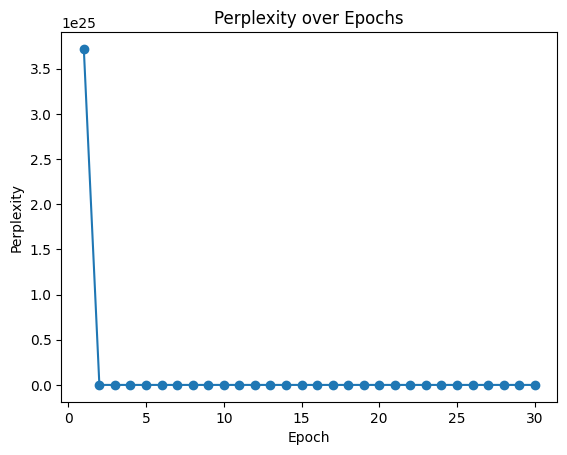

In [61]:
import matplotlib.pyplot as plt
import torch

# manually entering in number average loss values

estimated_perplexities = []
for lst in loss_per_epoch:
  estimated_perplexities.append(2**np.mean(lst))

# Plot the perplexity values
plt.plot(range(1, len(estimated_perplexities) + 1), estimated_perplexities, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity over Epochs')
plt.savefig('perplexity-epoch.png')
plt.show()


# BERTScore evaluation of model

### Getting translations

In [39]:
import pickle

SAVED_FILEPATH = "/content/sample_data/pickle_bahdanau.pkl"


def fetch_translation_data(filepath=SAVED_FILEPATH):
# Open the file in binary mode
  with open(SAVED_FILEPATH, 'rb') as file:

    # Call load method to deserialze
    data = pickle.load(file)
    # type := list of lists
    # data[0] := input texts (in english)
    # data[1] := machine translated texts
    # data[2] := expected translations (in spanish)
  dic = {
      "input (english)": [],
      "machine translation": [],
      "expected (spanish)": []
  }

  for (eng, mach, span) in data:
    dic["input (english)"].append(eng)
    dic["machine translation"].append(mach)
    dic["expected (spanish)"].append(span)

  return dic

In [40]:
dic = fetch_translation_data()
print(type(dic))

<class 'dict'>


In [41]:
inputs = dic["input (english)"]
candidates = dic["machine translation"]
references = dic["expected (spanish)"]

### Importing packages to evaluate translation qualities with BERTScores

In [37]:
!pip install transformers # If you are using collab, "!" is required to download
!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [42]:
# import dependencies and load model
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer

scorer = BERTScorer(model_type='bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [43]:
inputs = dic["input (english)"]
candidates = dic["machine translation"]
references = dic["expected (spanish)"]

In [44]:
def calculate_BERTScores(candidates=candidates, references=references):

  precisions, recalls, f1s = [], [], []

  for i in range(len(references)):
    P, R, F1 = scorer.score([candidates[i]], [references[i]])
    precisions.append(f"{P.mean():.4f}")
    recalls.append(f"{R.mean():.4f}")
    f1s.append(f"{F1.mean():.4f}")

  return precisions, recalls, f1s

In [45]:
precisions, recalls, f1s = calculate_BERTScores()
dic["precision"] = precisions
dic["recall"] = recalls
dic["F1"] = f1s

### Loading dataframe

In [46]:
def load_translation_data(data=dic):
  return pd.DataFrame(dic)

In [47]:
df = load_translation_data()
df.head()

,input (english),machine translation,expected (spanish),precision,recall,F1
0,tom will be at work on monday .,tom va a estar en el lunes .,tom estará trabajando el lunes .,0.8859,0.8387,0.8616
1,tell me more .,cuéntame más .,cuénteme más .,0.9535,0.9535,0.9535
2,i like listening to npr .,me gusta escuchar las cosas .,me gusta escuchar a la npr .,0.8844,0.8683,0.8762
3,the jet plane had passengers on board .,el plan necesita con los estados unidos .,el avión tenía pasajeros a bordo .,0.6451,0.6576,0.6513
4,my son can already count to one hundred .,mi hijo ya sabe contar demasiado .,mi hijo ya sabe contar hasta cien .,0.8754,0.8788,0.8771


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   input (english)      14000 non-null  object
 1   machine translation  14000 non-null  object
 2   expected (spanish)   14000 non-null  object
 3   precision            14000 non-null  object
 4   recall               14000 non-null  object
 5   F1                   14000 non-null  object
dtypes: object(6)
memory usage: 656.4+ KB


In [49]:
df.shape

(14000, 6)

In [50]:
df.describe()

,input (english),machine translation,expected (spanish),precision,recall,F1
count,14000,14000,14000,14000,14000,14000
unique,8743,8681,8828,3193,3295,3219
top,shall we dance ?,¿ por qué no llamaste ?,tengo que dar una clase mañana a las dos y med...,1.0000,1.0000,1.0000
freq,7,7,7,1239,1239,1239


# Graphs

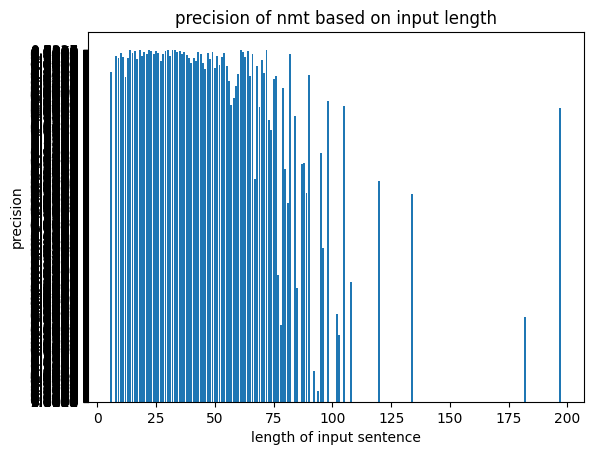

In [58]:
x = [len(term) for term in dic['input (english)']]
y1, y2, y3 = dic['precision'], dic['recall'], dic['F1']

plt.bar(x, y1)
plt.xlabel('length of input sentence')                    # Label x-axis
plt.ylabel('precision')               # Label y-axis
plt.title('precision of nmt based on input length')             # Set title
plt.savefig('precision-length.png')
plt.show()

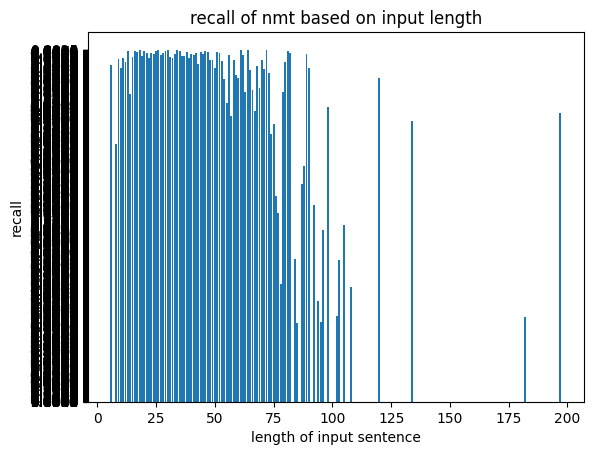

In [59]:
plt.bar(x, y2)
plt.xlabel('length of input sentence')                    # Label x-axis
plt.ylabel('recall')               # Label y-axis
plt.title('recall of nmt based on input length')             # Set title
plt.savefig('recall-length.png')
plt.show()

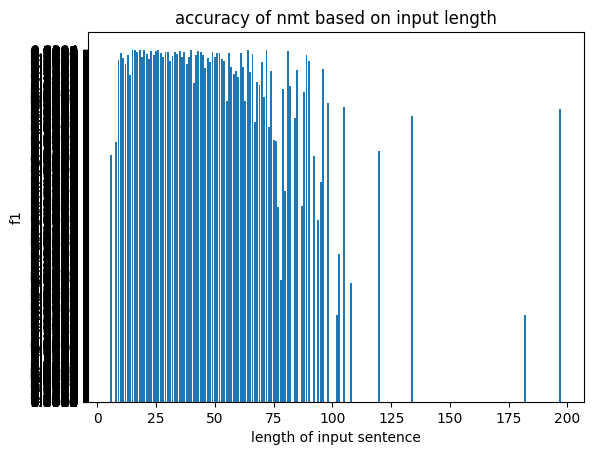

In [60]:
plt.bar(x, y3)
plt.xlabel('length of input sentence')                    # Label x-axis
plt.ylabel('f1')               # Label y-axis
plt.title('accuracy of nmt based on input length')             # Set title
plt.savefig('f1-length.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>